# 1-D Parameter Estimation: Likelihood vs. Eccentricity for Eccentric Injections over a range of SNRs

Simona Miller, LIGO SURF 2018 (Last edited: August 6, 2018)

In [1]:
import pycbc.noise
import pycbc.psd
from pycbc.filter import get_cutoff_indices
from pycbc.filter.matchedfilter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation

import numpy as np
from scipy.signal.windows import tukey

import emcee

import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)

## Noise PSD

In [3]:
# The color of the noise matches a PSD which you provide
f_lower = 20.0
f_upper = 300.0
delta_f = 1.0 / 8
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.analytical.aLIGODesignSensitivityP1200087(flen, delta_f, f_lower)

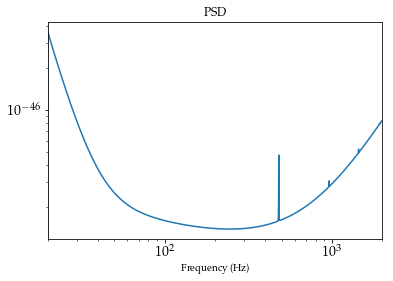

In [4]:
plt.loglog(psd.sample_frequencies, psd)
plt.xlim(f_lower, 2000)
plt.title('PSD')
plt.xlabel('Frequency (Hz)')
plt.show()

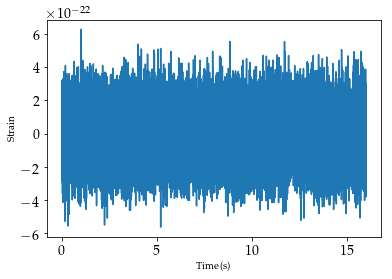

In [5]:
# Generating 16 seconds of noise at 2048 Hz
delta_t = 1.0 / 2048
tsamples = int(16 / delta_t)
noise_ex = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

plt.plot(noise_ex.sample_times, noise_ex)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

## Functions: gen_ecc_waveform, Injection,  loglikelihood, Normalize, SNRtoDistance

In [6]:
def gen_ecc_waveform(theta,
                     delta_t=delta_t,
                     delta_f=delta_f,
                     f_lower=f_lower,
                     duration=noise_ex.duration,
                     start_time=noise_ex.start_time):
    
    eccentricity, mass, distance = theta
    
    hp, hc = get_td_waveform(approximant="EccentricTD",
                             mass1=mass,
                             mass2=mass,
                             eccentricity=eccentricity,
                             delta_t=delta_t,
                             delta_f=delta_f, 
                             f_lower=f_lower, 
                             distance=distance)
    
    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time-8)
    hp.start_time = start_time
    
    return hp

In [7]:
def Injection(theta, delta_t=delta_t,delta_f=delta_f,f_lower=f_lower):   
        
    # Generate noise
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=np.random.randint(100))
    
    # Generate waveform template
    eccentricity, mass, distance = theta
    hp, hc = get_td_waveform(approximant="EccentricTD",
                         mass1=mass,
                         mass2=mass,
                         delta_t=delta_t,
                         delta_f=delta_f,
                         eccentricity=eccentricity,
                         f_lower=f_lower, 
                         distance=distance)
    
    # Window for template
    window_template = tukey(len(hp), alpha=0.01)
    for i in range(len(hp)):
        hp[i] = hp[i]*window_template[i]
    
    # Resizing template to match noise
    hp.resize(len(noise))
    template = hp.cyclic_time_shift(hp.start_time-noise.duration/2) # waveform injected halfway through noise
    template._epoch = 0 # setting start time to 0
    
    # Adding template and noise 
    template_with_noise = template + noise
    
    # Window for signal with noise
    window_noise = tukey(len(template_with_noise), alpha=0.01)
    for i in range(len(template_with_noise)):
        template_with_noise[i] = template_with_noise[i]*window_noise [i]
            
    return template_with_noise

In [8]:
def loglikelihood(theta, data, f_lower=f_lower, f_upper=f_upper, psd=psd):
    
    # Data
    df = data.to_frequencyseries()
    
    N = int(df.duration/df.delta_t)
    
    # Template
    template = gen_ecc_waveform(theta)
    hf = template.to_frequencyseries()
    
    # PSD
    psd = interpolate(psd, data.delta_f)
    
    f_upper = hf.sample_frequencies[-1]
    
    kmin, kmax = get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)
    
    # Calculating phase of best fit
    phase = sum(4.0 * df.delta_f * (hf[kmin:kmax].imag().conj()*df[kmin:kmax]).real()/psd[kmin:kmax])
    phase = phase/sum(4.0 * df.delta_f * (hf[kmin:kmax].real().conj()*df[kmin:kmax]).real()/psd[kmin:kmax])
    phase = np.arctan(phase)
    phase = np.exp(complex(0,phase))
    print phase
    hf = phase*hf
    
    # Calc likelihood
    print 'Summing for e={}... '.format(theta[0])
    h_minus_d = hf[kmin:kmax]-df[kmin:kmax]
    loglikelihood=-0.5 * sum(4.0 * df.delta_f * (h_minus_d.conj()*h_minus_d).real()/psd[kmin:kmax])   
    
    return loglikelihood

In [9]:
def Normalize(lnlikelihood_dist, de): 
    
    lnlik = [x-max(lnlikelihood_dist)+20 for x in lnlikelihood_dist]
    
    norm_const = 1.0/(np.sum(np.exp(lnlik[:]))*de)
    
    norm = [norm_const*np.exp(x) for x in lnlik]
 
    return norm 

In [10]:
def SNRtoDistance(SNR, ecc, mass, psd=psd, f_lower=f_lower):
    theta0 = (ecc, mass, 1) # distance of 1 Mpc
    template0 = gen_ecc_waveform(theta0)
    data0 = Injection(theta0)
    psd0 = interpolate(psd, data0.delta_f)
    SNR0 = max(np.absolute(matched_filter(template0,data0,psd=psd0,low_frequency_cutoff=f_lower)))
    distance = int(float(SNR0)/SNR)
    return distance

## Main Function: Likelihood distribution

In [11]:
def LikelihoodDistribution(true_ecc,mass,distance,ecc_range,de):
    
    theta_data = (true_ecc,mass,distance)
    data = Injection(theta_data)
    print 'Generated data for d={}, m={}, e={}'.format(distance,mass,true_ecc)
        
    ln_likelihood=[]
    for e in ecc_range: 
        theta = (e,mass,distance)
        ln_likelihood.append(loglikelihood(theta, data))     
        
    print 'Completed likelihood distribution calc for inj with  d={}, m={}'.format(distance,mass) 
        
    norm = Normalize(ln_likelihood,de) 
        
    print 'Normalized data for d={}, m={}'.format(distance,mass)  
    print  'Sum', np.sum(norm[:])*de
                    
    return norm

In [15]:
# Testing
mass = [5, 20, 60]
SNR = [5,10,50,100]

#log_true_ecc = np.arange(-5,0)
#true_ecc = [10.0**e for e in log_true_ecc]

#log_de = 0.25
#log_ecc_range = np.arange(-8,1,log_de)
#ecc_range = [10.0**e for e in log_ecc_range]

true_ecc = [0.05]

de = 0.001
ecc_range = np.arange(0.001, 0.1, de)

In [16]:
likelihood = {}

for m in mass: 
    for snr in SNR: 
        for e0 in true_ecc: 
            
            key = (m,snr,e0)
            
            distance = SNRtoDistance(snr, e0, m)
            
            likelihood[key] = LikelihoodDistribution(e0, m, distance, ecc_range, de)

Generated data for d=949, m=5, e=0.05
(0.891200583341-0.453609435806j)
Summing for e=0.001... 
(0.51243125088-0.858728253362j)
Summing for e=0.002... 
(0.727325062241-0.686293125302j)
Summing for e=0.003... 
(0.654915490018-0.755702124474j)
Summing for e=0.004... 
(0.989443420956-0.144919690612j)
Summing for e=0.005... 
(0.547148835066-0.837035335148j)
Summing for e=0.006... 
(0.531186261763-0.847255070988j)
Summing for e=0.007... 
(0.978192361641-0.207700995732j)
Summing for e=0.008... 
(0.557572799008-0.830128046633j)
Summing for e=0.009... 
(0.620272103384-0.784386714423j)
Summing for e=0.01... 
(0.352990463169-0.935626919724j)
Summing for e=0.011... 
(0.762679042913-0.646777146706j)
Summing for e=0.012... 
(0.851353157939-0.52459298553j)
Summing for e=0.013... 
(0.700554801507-0.71359860572j)
Summing for e=0.014... 
(0.976706366511-0.214580226529j)
Summing for e=0.015... 
(0.372374515799-0.928082550199j)
Summing for e=0.016... 
(0.990447281697-0.137891922092j)
Summing for e=0.017..

(0.860747028601-0.509032958417j)
Summing for e=0.044... 
(0.986694781773-0.162583540439j)
Summing for e=0.045... 
(0.990082476424-0.140487329954j)
Summing for e=0.046... 
(0.745363763338+0.666657978504j)
Summing for e=0.047... 
(0.999826684601+0.0186172167743j)
Summing for e=0.048... 
(0.985928026295+0.16717035313j)
Summing for e=0.049... 
(0.998291265143-0.0584341504549j)
Summing for e=0.05... 
(0.847578111326+0.530670656057j)
Summing for e=0.051... 
(0.703834147346+0.710364338231j)
Summing for e=0.052... 
(0.796722107575+0.604345830879j)
Summing for e=0.053... 
(0.989553639196+0.144165166228j)
Summing for e=0.054... 
(0.878515463097+0.477713911352j)
Summing for e=0.055... 
(0.883865236704+0.467741641663j)
Summing for e=0.056... 
(0.217142230192+0.97613997555j)
Summing for e=0.057... 
(0.813889610655+0.581019536391j)
Summing for e=0.058... 
(0.74073875207+0.671793198226j)
Summing for e=0.059... 
(0.123585074463-0.99233398076j)
Summing for e=0.06... 
(0.484012628163+0.875061012604j)
Su

(0.268238297008-0.963352591743j)
Summing for e=0.087... 
(0.782430052419-0.622738478875j)
Summing for e=0.088... 
(0.933832801899-0.357709795921j)
Summing for e=0.089... 
(0.892141531903-0.451756003893j)
Summing for e=0.09... 
(0.567636705676-0.823279157012j)
Summing for e=0.091... 
(0.785795296953-0.618486662173j)
Summing for e=0.092... 
(0.766169167874-0.642638939218j)
Summing for e=0.093... 
(0.532392365807-0.846497707517j)
Summing for e=0.094... 
(0.930265725053-0.366886468533j)
Summing for e=0.095... 
(0.999054607107-0.0434728883146j)
Summing for e=0.096... 
(0.99864662562-0.0520088178865j)
Summing for e=0.097... 
(0.88559129934-0.464465338354j)
Summing for e=0.098... 
(0.996671614736-0.0815211161618j)
Summing for e=0.099... 
Completed likelihood distribution calc for inj with  d=95, m=5
Normalized data for d=95, m=5
Sum 1.0
Generated data for d=47, m=5, e=0.05
(0.849264519953-0.527967589109j)
Summing for e=0.001... 
(0.432378932079-0.90169199791j)
Summing for e=0.002... 
(0.66199

(0.996644699374+0.0818495156411j)
Summing for e=0.029... 
(0.995066943823+0.0992057322459j)
Summing for e=0.03... 
(0.99375557252+0.111578950013j)
Summing for e=0.031... 
(0.995205242979+0.0978086108063j)
Summing for e=0.032... 
(0.997098028263+0.076128326096j)
Summing for e=0.033... 
(0.972485189283+0.232964711116j)
Summing for e=0.034... 
(0.976009720348+0.217726952363j)
Summing for e=0.035... 
(0.978742038509+0.205095153661j)
Summing for e=0.036... 
(0.984256789598+0.176744369443j)
Summing for e=0.037... 
(0.989979436044+0.141211600837j)
Summing for e=0.038... 
(0.994505813464+0.104681359302j)
Summing for e=0.039... 
(0.97670629705+0.214580542696j)
Summing for e=0.04... 
(0.985571534518+0.16925941731j)
Summing for e=0.041... 
(0.992750313478+0.120194904588j)
Summing for e=0.042... 
(0.977071241343+0.212912633115j)
Summing for e=0.043... 
(0.987922783564+0.154947002922j)
Summing for e=0.044... 
(0.972030017659+0.234856647277j)
Summing for e=0.045... 
(0.986013216676+0.166667142955j)


(0.994073829262-0.108707046578j)
Summing for e=0.071... 
(0.999610362364+0.0279127830107j)
Summing for e=0.072... 
(0.998755195481-0.0498804520768j)
Summing for e=0.073... 
(0.992121032868-0.12528310397j)
Summing for e=0.074... 
(0.999913378798-0.013161872995j)
Summing for e=0.075... 
(0.99635600829-0.0852918797059j)
Summing for e=0.076... 
(0.98097803377-0.194118771015j)
Summing for e=0.077... 
(0.994388085637-0.1057938332j)
Summing for e=0.078... 
(0.978673282394-0.20542299367j)
Summing for e=0.079... 
(0.99278501659-0.119907926488j)
Summing for e=0.08... 
(0.998872795487-0.0474672354039j)
Summing for e=0.081... 
(0.985445101068-0.169993978664j)
Summing for e=0.082... 
(0.99480800774-0.101769483326j)
Summing for e=0.083... 
(0.972521736494-0.232812096005j)
Summing for e=0.084... 
(0.984072823039-0.177765798047j)
Summing for e=0.085... 
(0.992149146582-0.125060269216j)
Summing for e=0.086... 
(0.996187587653-0.0872369772836j)
Summing for e=0.087... 
(0.973757421884-0.227588407713j)
Su

(0.999395623337-0.0347618764697j)
Summing for e=0.011... 
(0.995035318015-0.0995224391883j)
Summing for e=0.012... 
(0.999956338201+0.00934460767004j)
Summing for e=0.013... 
(0.997764053758-0.0668348189889j)
Summing for e=0.014... 
(0.988806147087-0.14920590968j)
Summing for e=0.015... 
(0.998387581605-0.0567647504721j)
Summing for e=0.016... 
(0.988561023054-0.150821429839j)
Summing for e=0.017... 
(0.997511635545-0.0705020350906j)
Summing for e=0.018... 
(0.999986920143+0.00511464006126j)
Summing for e=0.019... 
(0.994333492147-0.106305721367j)
Summing for e=0.02... 
(0.999090685351-0.042635694504j)
Summing for e=0.021... 
(0.999893897736+0.0145668552069j)
Summing for e=0.022... 
(0.993440094637-0.114353742256j)
Summing for e=0.023... 
(0.997726397578-0.0673946257256j)
Summing for e=0.024... 
(0.999649821414-0.0264619452492j)
Summing for e=0.025... 
(0.999975872211+0.00694658156959j)
Summing for e=0.026... 
(0.999360819801+0.035748452365j)
Summing for e=0.027... 
(0.998270207395+0.0

(0.936984975664+0.349369654349j)
Summing for e=0.053... 
(0.940152379106+0.340754316277j)
Summing for e=0.054... 
(0.939973650464+0.34124703139j)
Summing for e=0.055... 
(0.942967217132+0.332885607101j)
Summing for e=0.056... 
(0.945928639049+0.324374798384j)
Summing for e=0.057... 
(0.948854875525+0.315712567365j)
Summing for e=0.058... 
(0.948393787577+0.317094975811j)
Summing for e=0.059... 
(0.951271114101+0.308355748247j)
Summing for e=0.06... 
(0.954108658106+0.299460629345j)
Summing for e=0.061... 
(0.956407631917+0.292035000662j)
Summing for e=0.062... 
(0.958929994893+0.283642847425j)
Summing for e=0.063... 
(0.961412973899+0.275109239427j)
Summing for e=0.064... 
(0.963853760764+0.266431844684j)
Summing for e=0.065... 
(0.965478285587+0.260483550459j)
Summing for e=0.066... 
(0.967730445409+0.251987668407j)
Summing for e=0.067... 
(0.969935389823+0.243362568136j)
Summing for e=0.068... 
(0.970905142914+0.239464409598j)
Summing for e=0.069... 
(0.973010703253+0.230759986469j)


(0.712447404108-0.701725513559j)
Summing for e=0.095... 
(0.713000027662-0.701164004035j)
Summing for e=0.096... 
(0.701956758712-0.712219565091j)
Summing for e=0.097... 
(0.707717687291-0.706495346832j)
Summing for e=0.098... 
(0.696130218707-0.717915537235j)
Summing for e=0.099... 
Completed likelihood distribution calc for inj with  d=3119, m=60
Normalized data for d=3119, m=60
Sum 1.0
Generated data for d=623, m=60, e=0.05
(0.969914589887+0.24344545246j)
Summing for e=0.001... 
(0.97088181745+0.239558962564j)
Summing for e=0.002... 
(0.971859453147+0.235561464016j)
Summing for e=0.003... 
(0.972846081285+0.231453023591j)
Summing for e=0.004... 
(0.973840256121+0.227233702514j)
Summing for e=0.005... 
(0.974840501944+0.222903557104j)
Summing for e=0.006... 
(0.97584531314+0.218462639421j)
Summing for e=0.007... 
(0.97685315425+0.213910997922j)
Summing for e=0.008... 
(0.977862460012+0.209248678132j)
Summing for e=0.009... 
(0.97887163539+0.204475723326j)
Summing for e=0.01... 
(0.97

(0.997952150037+0.0639648828331j)
Summing for e=0.037... 
(0.998477769695+0.0551556291356j)
Summing for e=0.038... 
(0.998930339071+0.0462404334207j)
Summing for e=0.039... 
(0.999307101036+0.0372198578612j)
Summing for e=0.04... 
(0.998940091617+0.0460292663429j)
Summing for e=0.041... 
(0.999327945812+0.0366559233893j)
Summing for e=0.042... 
(0.999630645757+0.0271766823309j)
Summing for e=0.043... 
(0.999845244982+0.0175922166336j)
Summing for e=0.044... 
(0.999968768835+0.00790324964857j)
Summing for e=0.045... 
(0.999885849295+0.0151092150672j)
Summing for e=0.046... 
(0.999986953646+0.00510808546945j)
Summing for e=0.047... 
(0.999987508233-0.00499833749892j)
Summing for e=0.048... 
(0.999884333045-0.0152092252132j)
Summing for e=0.049... 
(0.99995608772-0.00937137294359j)
Summing for e=0.05... 
(0.999802466621-0.0198753047655j)
Summing for e=0.051... 
(0.999535259886-0.030483835805j)
Summing for e=0.052... 
(0.999151084673-0.0411959949102j)
Summing for e=0.053... 
(0.99864652552

## Plotting

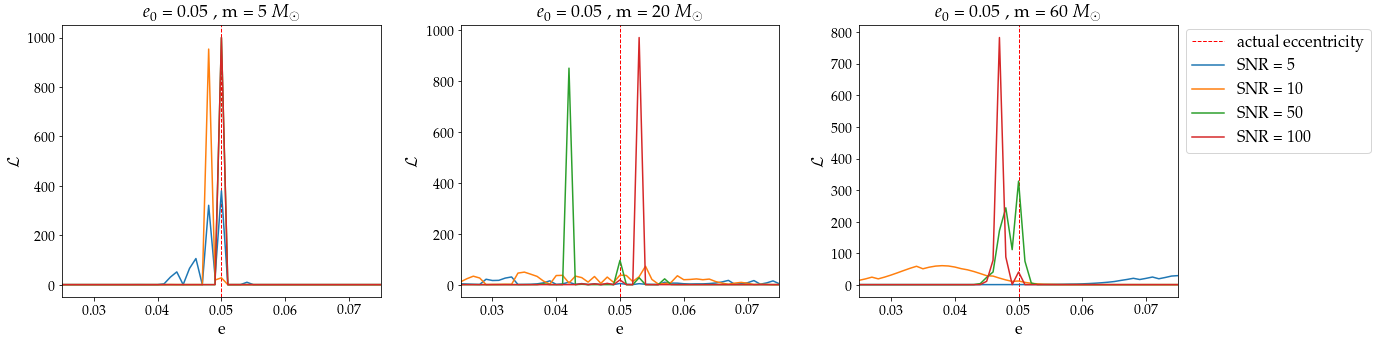

In [18]:
plt.figure(figsize=(20,5))

i = 1

for m in mass:
    for e0 in true_ecc: 
        
        plt.subplot(len(true_ecc),len(mass),i)
        plt.title(r'$e_0$ = {} , m = {} $M_\odot$'.format(e0, m), fontsize=18)
        plt.xlabel('e', fontsize=16)
        plt.ylabel(r'$\mathcal{L}$', fontsize=16)
        plt.axvline(x=e0, color='r', linestyle='dashed', linewidth=1.0, label='actual eccentricity')
    
        for snr in SNR: 
                
            key = (m,snr,e0)
            lik = likelihood[key]
            plt.plot(ecc_range, lik, label="SNR = {}".format(snr))
            plt.xlim(0.025,0.075)
        
        i+=1

plt.legend(fontsize=16,loc='lower left', bbox_to_anchor=(1, 0.5)) 
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('likelihood_plots_2.png')
plt.show()